<a href="https://colab.research.google.com/github/Nicolas-Nav/DeepLearning/blob/main/Base_Estructura_EA3_Transformer_NLP_alumnos_Final(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementación de Transformers para Procesamiento de Lenguaje Natural (NLP)


### Objetivo
En esta evaluación, implementaremos un modelo basado en arquitecturas de Transformers para una tarea de procesamiento de lenguaje natural (NLP), utilizando el dataset **DailyDialog**. Este conjunto de datos de diálogos permite que el modelo practique en generación de texto y comprensión de contexto en interacciones cotidianas.

Usaremos TensorFlow para construir un modelo transformer básico con las siguientes características:
- **Encoder-Decoder**: para procesar la entrada y generar salida secuencial.
- **Atención Multi-cabezal**: para capturar dependencias a largo plazo en el diálogo.

Al final, evaluaremos el modelo utilizando métricas específicas de NLP, como BLEU o ROUGE.


## 0. Importaciones y funciones

In [ ]:
import pandas as pd
import numpy as np
import re
import ast
import matplotlib.pyplot as plt

import nltk
from nltk.tokenize import word_tokenize
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import (Input, Embedding, Dense, Dropout, LayerNormalization, MultiHeadAttention, Add)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping

Para visualizar el comportamiento del modelo durante el entrenamiento, se define una función que grafica la evolución de la pérdida (loss) a lo largo de las épocas. Esta visualización permite evaluar si el modelo está aprendiendo correctamente. A continuación, se muestra la función graficar_historial_entrenamiento, la cual toma como entrada el historial (History) generado por el método fit() de Keras.  

In [ ]:
def graficar_historial_entrenamiento(hist):
    """
    Grafica la pérdida del entrenamiento a lo largo de las épocas.

    Parámetros:
    hist -- Objeto History devuelto por el método fit() de un modelo Keras.

    ###Dejo el comentario igual como lo hace la profe en sus notes
    """
    epocas = range(1, len(hist.history['loss']) + 1)

    plt.figure(figsize=(8, 6))
    plt.plot(epocas, hist.history['loss'], label="Pérdida de entrenamiento", color='blue')
    plt.plot(epocas, hist.history['val_loss'], label="Pérdida de validación", color='red')
    plt.title('Pérdida del entrenamiento', fontsize=14, fontweight="bold")
    plt.xlabel('Época', fontsize=12, fontweight="bold")
    plt.ylabel('Pérdida', fontsize=12, fontweight="bold")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

## 1. Carga y Exploración del Dataset: DailyDialog

En esta sección descargamos el dataset DailyDialog, el cual se encuentra dividido en conjuntos de entrenamiento, validación y prueba,. Cada archivo contiene diálogos en formato estructurado, donde cada fila representa una línea dentro de una conversación. Este dataset es ampliamente utilizado en tareas de modelado de diálogo, ya que permite entrenar y evaluar modelos de generación y comprensión de lenguaje en contextos conversacionales reales.

In [ ]:
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/train.csv
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/test.csv
!wget https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/validation.csv

--2025-06-24 02:38:43--  https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/train.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6233555 (5.9M) [text/plain]
Saving to: ‘train.csv’

train.csv           100%[===================>]   5.94M  --.-KB/s    in 0.02s   

2025-06-24 02:38:44 (285 MB/s) - ‘train.csv’ saved [6233555/6233555]

--2025-06-24 02:38:44--  https://raw.githubusercontent.com/JaznaLaProfe/Deep-Learning/main/data/dialog/test.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 561656 (548K

A continuación, cargamos los tres archivos CSV descargados previamente en dataframes de pandas: train, validation y test. Cada dataframe representa una parte distinta del corpus de diálogos, y será utilizada en diferentes etapas del entrenamiento y evaluación del modelo Transformer.

In [ ]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
validation = pd.read_csv('validation.csv')

Mostramos a continuación el contenido del dataframe train, que corresponde al conjunto de entrenamiento. Este conjunto contiene la mayor parte de los ejemplos y será utilizado para que el modelo aprenda patrones conversacionales.

In [ ]:
train

,dialog,act,emotion
0,"['Say , Jim , how about going for a few beers ...",[3 4 2 2 2 3 4 1 3 4],[0 0 0 0 0 0 4 4 4 4]
1,"['Can you do push-ups ? '\n "" Of course I can ...",[2 1 2 2 1 1],[0 0 6 0 0 0]
2,"['Can you study with the radio on ? '\n ' No ,...",[2 1 2 1 1],[0 0 0 0 0]
3,['Are you all right ? '\n ' I will be all righ...,[2 1 1 1],[0 0 0 0]
4,"['Hey John , nice skates . Are they new ? '\n ...",[2 1 2 1 1 2 1 3 4],[0 0 0 0 0 6 0 6 0]
...,...,...,...
11113,"['Hello , I bought a pen in your shop just bef...",[1 1 1 2 3 2 1 4 1],[0 4 0 0 0 0 0 0 4]
11114,['Do you have any seats available ? ' ' Yes . ...,[2 1 2 1 3 4],[0 0 0 0 0 4]
11115,"['Uncle Ben , how did the Forbidden City get t...",[2 1 2 1 1 1 1 1 2 1 2 1 2 1 3 4],[0 0 6 0 6 0 0 0 0 0 0 0 0 0 4 0]
11116,"['May I help you , sir ? ' ' I want a pair of ...",[2 3 4 3],[0 0 0 0]


El conjunto de datos de entrenamiento contiene 11.118 registros y 3 columnas: dialog, act y emotion. La columna dialog almacena una secuencia de oraciones que conforman un diálogo entre dos o más personas, representado como una lista de frases. Cada línea corresponde a un turno de habla dentro del diálogo. La columna act contiene una lista de números que representan la intención de la intervención, como preguntar, responder, sugerir o afirmar. Finalmente, la columna emotion incluye también una lista de etiquetas numéricas que identifican la emoción expresada en cada turno del diálogo, como neutralidad, alegría, sorpresa, tristeza, ira, miedo o desagrado. Las listas en act y emotion tienen la misma longitud que la cantidad de turnos en el diálogo, ya que asignan una etiqueta por cada intervención. Este formato estructurado permite analizar tanto el contenido textual como las funciones pragmáticas y emocionales de los diálogos.

A continuación, mostramos el primer ejemplo del conjunto de entrenamiento, accediendo a la columna dialog. En este proyecto nos enfocaremos únicamente en esta variable, ya que nuestro problema es de tipo predictivo, centrado en la generación de texto. En un enfoque clasificatorio, podríamos haber utilizado las columnas act o emotion como variable objetivo (y), pero en este caso nos interesa modelar la secuencia de diálogo para que el modelo aprenda a predecir respuestas coherentes dentro de una conversación.

In [ ]:
print(train['dialog'].iloc[0])

['Say , Jim , how about going for a few beers after dinner ? '
 ' You know that is tempting but is really not good for our fitness . '
 ' What do you mean ? It will help us to relax . '
 " Do you really think so ? I don't . It will just make us fat and act silly . Remember last time ? "
 " I guess you are right.But what shall we do ? I don't feel like sitting at home . "
 ' I suggest a walk over to the gym where we can play singsong and meet some of our friends . '
 " That's a good idea . I hear Mary and Sally often go there to play pingpong.Perhaps we can make a foursome with them . "
 ' Sounds great to me ! If they are willing , we could ask them to go dancing with us.That is excellent exercise and fun , too . '
 " Good.Let ' s go now . " ' All right . ']


##Procesamiento

En esta sección realizamos el procesamiento necesario para convertir los diálogos en pares de frases consecutivas que puedan ser utilizados para entrenar un modelo predictivo de generación de texto. Primero, definimos una función para extraer cada línea de diálogo individual de la representación original, que está almacenada como una cadena con múltiples oraciones. Luego, creamos pares de entrada y salida donde la frase anterior es la entrada y la frase siguiente la respuesta esperada. Esto permite al modelo aprender a predecir la próxima línea en una conversación, transformando el problema en una tarea de secuencia a secuencia. Finalmente, aplicamos este procesamiento a los conjuntos de entrenamiento, validación y prueba, y mostramos ejemplos y la cantidad total de pares generados en cada conjunto.

In [ ]:
def Separar(conversa):
    separar = r"""(['"])(.*?)(?<!\\)\1"""
    duplas = re.findall(separar, conversa)
    return [m[1].strip() for m in duplas if m[1].strip()]

def convertir_dataset(df):
    x, y = [], []
    for conversa in df['dialog']:
        frases = Separar(conversa)
        x.extend(frases[:-1])
        y.extend(frases[1:])
    return x, y

x_train, y_train = convertir_dataset(train)
x_test, y_test = convertir_dataset(test)
x_val, y_val = convertir_dataset(validation)

print("Ejemplo de par (train):")
print("Entrada:", x_train[1])
print("Respuesta:", y_train[1])

print("Cantidad de pares (train):", len(x_train))
print("Cantidad de pares (test):", len(x_test))
print("Cantidad de pares (validation):", len(x_val))

Ejemplo de par (train):
Entrada: You know that is tempting but is really not good for our fitness .
Respuesta: What do you mean ? It will help us to relax .
Cantidad de pares (train): 76052
Cantidad de pares (test): 6740
Cantidad de pares (validation): 7069


El resultado muestra un ejemplo claro de cómo se estructuran los pares de diálogo para el entrenamiento del modelo. La frase de entrada corresponde a una línea del diálogo, mientras que la respuesta es la frase inmediatamente siguiente, que el modelo intentará predecir. Además, se observa que el procesamiento generó un total de 76.052 pares para entrenamiento, 6.740 para prueba y 7.069 para validación, asegurando una cantidad suficiente de datos para entrenar y evaluar el modelo de manera efectiva.

##Tokenizar

En esta etapa realizamos la tokenización básica agregando tokens especiales de inicio y fin a cada frase de respuesta. Estos tokens (starttoken y endtoken) son importantes para que el modelo pueda identificar claramente dónde comienza y termina cada secuencia durante el entrenamiento y la generación de texto. Esta práctica facilita el aprendizaje de la estructura del diálogo y mejora la capacidad del modelo para generar respuestas coherentes y completas.

In [ ]:
def agregar_tokens(respuestas):
    return [f'starttoken {r} endtoken' for r in respuestas]

y_train_tok = agregar_tokens(y_train)
y_test_tok = agregar_tokens(y_test)
y_val_tok = agregar_tokens(y_val)

En este paso creamos y entrenamos un tokenizador de TensorFlow para convertir el texto en secuencias numéricas que el modelo pueda procesar. Limitamos el vocabulario a las 20.000 palabras más frecuentes y definimos un token especial para palabras fuera del vocabulario (<OOV>). El tokenizador se ajusta tanto a las frases de entrada como a las respuestas con tokens especiales, asegurando una representación consistente del lenguaje utilizado en todos los conjuntos de datos. Además, invertimos el diccionario de índices para facilitar la conversión de números a palabras durante la generación de texto.

In [ ]:
tokenizer = Tokenizer(num_words=20000, oov_token='<OOV>')
tokenizer.fit_on_texts(x_train + y_train_tok + x_val + y_val_tok)
tokenizer.index_word = {v: k for k, v in tokenizer.word_index.items()}

El parámetro num_words=20000 se eligió porque el vocabulario real del dataset es de aproximadamente 18.734 palabras más 3 tokens especiales (oov_token, starttoken, endtoken). Esto asegura que el tokenizador cubra casi todas las palabras importantes, limitando el vocabulario para evitar incluir términos muy raros que no aportan mucho. Es buena práctica ajustar num_words al tamaño real del vocabulario más los tokens especiales para optimizar la representación y el uso de recursos. La variable word_index muestra la asignación de cada palabra a un índice único para convertir texto en secuencias numéricas.

In [ ]:
print(tokenizer.word_index)

{'<OOV>': 1, 'starttoken': 2, 'endtoken': 3, 'you': 4, 'i': 5, 'the': 6, 'to': 7, 'a': 8, 'it': 9, 'and': 10, 'is': 11, 'of': 12, '’': 13, 'in': 14, 'that': 15, 'have': 16, 'for': 17, 'do': 18, 'are': 19, 'what': 20, 'your': 21, 'we': 22, 'can': 23, 'my': 24, 'me': 25, 'be': 26, 'this': 27, 'on': 28, 'but': 29, 'like': 30, 'yes': 31, 'with': 32, 'how': 33, 'so': 34, 'about': 35, 'will': 36, 's': 37, 'at': 38, 'there': 39, 'not': 40, 'well': 41, "it's": 42, "i'm": 43, 'no': 44, 'think': 45, 'know': 46, 'good': 47, 'all': 48, 'just': 49, 'would': 50, 'get': 51, 'if': 52, 'one': 53, 'here': 54, 'go': 55, 'was': 56, 'they': 57, 't': 58, "don't": 59, 'right': 60, 'see': 61, 'very': 62, 'really': 63, 'some': 64, 'time': 65, 'want': 66, 'he': 67, 'please': 68, 'oh': 69, 'as': 70, 'much': 71, 'take': 72, "that's": 73, 'our': 74, 'need': 75, 'too': 76, 'now': 77, 'up': 78, 'an': 79, 'out': 80, 'or': 81, 'sure': 82, 'from': 83, 'going': 84, 'when': 85, 'ok': 86, 'am': 87, 'did': 88, 'then': 89, 

Con el diccionario creado podemos tokenizar las secuencias de entrada y salida generadas con la funcion convertir_dataset.

Ahora, convertimos las frases de entrada y las respuestas tokenizadas en secuencias numéricas usando el tokenizador previamente entrenado. Estas secuencias son la representación que el modelo puede procesar para aprender patrones en los datos textuales y generar predicciones durante el entrenamiento y la evaluación.

In [ ]:
x_train_seq = tokenizer.texts_to_sequences(x_train)
x_test_seq = tokenizer.texts_to_sequences(x_test)
x_val_seq = tokenizer.texts_to_sequences(x_val)

y_train_seq = tokenizer.texts_to_sequences(y_train_tok)
y_test_seq = tokenizer.texts_to_sequences(y_test_tok)
y_val_seq = tokenizer.texts_to_sequences(y_val_tok)

Imprimimos el resultado de tokenizar las secuencias de entrada y salida.

In [ ]:
print("Entrada (tokenizada):", x_train_seq[0])
print("Respuesta (tokenizada):", y_train_seq[0])

Entrada (tokenizada): [154, 1139, 33, 35, 84, 17, 8, 204, 3420, 161, 322]
Respuesta (tokenizada): [2, 4, 46, 15, 11, 4330, 29, 11, 63, 40, 47, 17, 74, 2254, 3]


##Padding

En esta sección aplicamos padding a las secuencias numéricas para que todas tengan la misma longitud, lo cual es necesario para que el modelo pueda procesarlas en lotes uniformes durante el entrenamiento. Calculamos la longitud máxima de entrada y de salida, y usamos la mayor como referencia para las entradas, mientras que para las salidas usamos su propia longitud máxima. El padding se añade al final de cada secuencia (padding='post'), rellenando con ceros donde las secuencias son más cortas. Esto permite que el modelo maneje secuencias variables manteniendo la coherencia en la forma de los datos, optimizando el entrenamiento y la eficiencia computacional.

In [ ]:
max_input_len = max(map(len, x_train_seq + x_val_seq + x_test_seq))
max_target_len = max(map(len, y_train_seq + y_val_seq + y_test_seq))
max_len = max(max_input_len, max_target_len)
vocab_size = min(20000, len(tokenizer.word_index) + 1)

x_train_pad = pad_sequences(x_train_seq, maxlen=max_len, padding='post')
x_test_pad = pad_sequences(x_test_seq, maxlen=max_len, padding='post')
x_val_pad = pad_sequences(x_val_seq, maxlen=max_len, padding='post')

y_train_pad = pad_sequences(y_train_seq, maxlen=max_target_len, padding='post')
y_test_pad = pad_sequences(y_test_seq, maxlen=max_target_len, padding='post')
y_val_pad = pad_sequences(y_val_seq, maxlen=max_target_len, padding='post')

Imprimimos el resultado del padding a las secuencias de entrada y salida.

In [ ]:
print("Entrada (tokenizada):", x_train_pad[0])
print("Respuesta (tokenizada):", y_train_pad[0])

reverse_index = {v: k for k, v in tokenizer.word_index.items()}
print("Entrada (con palabras):", [reverse_index.get(i, '?') for i in x_train_seq[0]])
print("Respuesta (con palabras):", [reverse_index.get(i, '?') for i in y_train_seq[0]])

Entrada (tokenizada): [ 154 1139   33   35   84   17    8  204 3420  161  322    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0

Imprimimos las dimensiones de las matrices con secuencias con padding para verificar que todas tengan la misma longitud y la cantidad correcta de muestras en cada conjunto (entrenamiento, prueba y validación). Además, calculamos y mostramos la longitud mínima y máxima de las secuencias, confirmando que el padding fue aplicado correctamente y que todas las secuencias tienen una longitud uniforme para ser procesadas por el modelo.

In [ ]:
print(x_train_pad.shape)
print(x_test_pad.shape)
print(x_val_pad.shape)

all_lengths = [len(seq) for seq in x_train_pad]
print("Min length:", min(all_lengths), "Max length:", max(all_lengths))

(76052, 258)
(6740, 258)
(7069, 258)
Min length: 258 Max length: 258


El resultado de este bloque de código indica que todas las secuencias de entrada (x_train_pad, x_test_pad, x_val_pad) han sido rellenadas para que tengan una longitud fija de 258 tokens. Esto se hace porque los modelos como el Transformer requieren que todas las entradas tengan la misma longitud.

El padding añade ceros al final de las secuencias más cortas para igualar su longitud, pero esos ceros no representan palabras reales, sino espacios de relleno. Por eso, durante el entrenamiento del modelo es fundamental usar máscaras de padding, que indican cuáles posiciones corresponden a datos válidos y cuáles son solo relleno. Estas máscaras permiten que el mecanismo de atención y otras capas del Transformer ignoren los ceros, evitando que influyan en el cálculo y la generación de resultados, lo que mejora la precisión y eficiencia del modelo.

## 2. Implementación del Modelo Transformer

En este trabajo se implementa una arquitectura Transformer personalizada, diseñada para tareas de secuencia a secuencia (seq2seq) en lenguaje natural. A diferencia de modelos tradicionales como RNN o LSTM, que procesan las secuencias de forma secuencial, el Transformer permite un procesamiento completamente paralelo y captura relaciones a largo plazo de manera más eficiente. Su diseño se basa exclusivamente en mecanismos de atención, eliminando la necesidad de recurrencias.

Estructura general del modelo
El modelo está compuesto por dos bloques principales: un encoder y un decoder, cada uno con atención multi-cabezal (Multi-Head Attention), normalización por capas (Layer Normalization), conexiones residuales y redes feed-forward densas. Ambos módulos trabajan sobre representaciones densas generadas por capas de embedding, a las que se suma una codificación posicional (positional_encoding) para preservar el orden de las palabras, ya que el modelo no posee mecanismos internos para inferir la posición por sí solo.

El encoder se encarga de procesar la entrada y generar una representación contextualizada de cada palabra.

El decoder genera la salida de manera autoregresiva, atendiendo tanto a su propia entrada pasada como a la representación completa generada por el encoder, integrando mecanismos de atención causal y cruzada.

Uso de 4 cabezas de atención
Se utilizan 4 cabezas de atención en cada bloque de atención multi-cabezal. Esto permite que el modelo se enfoque en diferentes partes de la secuencia en paralelo. En otras palabras, cada cabeza aprende a capturar distintos patrones de dependencia (por ejemplo: sujeto-verbo, pregunta-respuesta, negación, etc.), lo que en conjunto enriquece la capacidad del modelo para entender y generar lenguaje. Este número se elige como un compromiso entre capacidad de modelado y eficiencia computacional.

Salida y predicción
La salida del decoder pasa por una capa final Dense con activación softmax, que asigna una probabilidad a cada palabra del vocabulario en cada paso temporal. Esta distribución probabilística permite seleccionar la palabra más adecuada en función del contexto anterior.

In [ ]:
def positional_encoding(seq_len, d_model):
    pos = np.arange(seq_len)[:, np.newaxis]
    i = np.arange(d_model)[np.newaxis, :]
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    angle_rads = pos * angle_rates
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    return tf.constant(angle_rads[np.newaxis, ...], dtype=tf.float32)

def encoder(embed_dim, num_heads, ff_dim, dropout=0.1):
    x = Input(shape=(None, embed_dim))
    attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x)
    attn = Dropout(dropout)(attn)
    x1 = LayerNormalization(epsilon=1e-6)(x + attn)
    ff = Dense(ff_dim, activation='relu')(x1)
    ff = Dense(embed_dim)(ff)
    ff = Dropout(dropout)(ff)
    x2 = LayerNormalization(epsilon=1e-6)(x1 + ff)
    return Model(inputs=x, outputs=x2, name="Encoder")

def decoder(embed_dim, num_heads, ff_dim, dropout=0.1):
    x = Input(shape=(None, embed_dim))
    enc_out = Input(shape=(None, embed_dim))
    self_attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x, x, use_causal_mask=True)
    self_attn = Dropout(dropout)(self_attn)
    x1 = LayerNormalization(epsilon=1e-6)(x + self_attn)
    cross_attn = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)(x1, enc_out)
    cross_attn = Dropout(dropout)(cross_attn)
    x2 = LayerNormalization(epsilon=1e-6)(x1 + cross_attn)
    ff = Dense(ff_dim, activation='relu')(x2)
    ff = Dense(embed_dim)(ff)
    ff = Dropout(dropout)(ff)
    x3 = LayerNormalization(epsilon=1e-6)(x2 + ff)
    return Model(inputs=[x, enc_out], outputs=x3, name="Decoder")

def creatransformer(vocab_size, max_len, embed_dim=64, num_heads=4, ff_dim=128, dropout=0.2):
    enc_in = Input(shape=(max_len,), name="Encoder_Input")
    dec_in = Input(shape=(max_len,), name="Decoder_Input")

    enc_embed = Embedding(vocab_size, embed_dim, mask_zero=True)(enc_in)
    dec_embed = Embedding(vocab_size, embed_dim, mask_zero=True)(dec_in)

    pos_encoding = positional_encoding(max_len, embed_dim)

    enc_pos = Add()([enc_embed, pos_encoding[:, :max_len, :]])
    dec_pos = Add()([dec_embed, pos_encoding[:, :max_len, :]])

    enc_out = encoder(embed_dim, num_heads, ff_dim, dropout)(enc_pos)
    dec_out = decoder(embed_dim, num_heads, ff_dim, dropout)([dec_pos, enc_out])

    out = Dense(vocab_size, activation='softmax')(dec_out)

    return Model(inputs=[enc_in, dec_in], outputs=out, name="transf")

## 3. Entrenamiento del Modelo

Calculamos la longitud máxima entre las secuencias de entrada y salida para definir un tamaño uniforme que facilite el procesamiento del modelo. Además, definimos el tamaño del vocabulario (vocab_size) como el mínimo entre el límite establecido de 20.000 palabras y el tamaño real del diccionario más uno (para incluir el token de padding). Esto asegura que el modelo trabaje con un vocabulario manejable y acorde a los datos disponibles.

In [ ]:
max_len = max(max_input_len, max_target_len)
vocab_size = min(20000, len(tokenizer.word_index) + 1)

En esta sección preparamos los datos para alimentar correctamente el decoder durante el entrenamiento. Para ello, dividimos las secuencias objetivo en dos partes: una para la entrada al decoder (excluyendo el último token) y otra para el objetivo o etiqueta (excluyendo el primer token). Esto permite que el modelo aprenda a predecir la siguiente palabra en la secuencia, paso a paso.

Posteriormente, instanciamos el modelo Transformer previamente definido, compilándolo con el optimizador Adam y la función de pérdida sparse_categorical_crossentropy. Finalmente, mostramos el resumen de la arquitectura, con los detalles de capas y parámetros a entrenar.

In [ ]:
def preparar_decoder_data(targets_tensor, max_len):
    decoder_input = targets_tensor[:, :-1]
    decoder_target = targets_tensor[:, 1:]
    decoder_input = pad_sequences(decoder_input, maxlen=max_len, padding='post')
    decoder_target = pad_sequences(decoder_target, maxlen=max_len, padding='post')
    return decoder_input, decoder_target

decoder_in_train, decoder_target_train = preparar_decoder_data(y_train_pad, max_len)
decoder_in_val, decoder_target_val = preparar_decoder_data(y_val_pad, max_len)
decoder_in_test, decoder_target_test = preparar_decoder_data(y_test_pad, max_len)

In [ ]:
model = creatransformer(vocab_size=vocab_size, max_len=max_len)
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "transf"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ Encoder_Input       │ (None, 258)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder_Input       │ (None, 258)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 258, 64)   │  1,199,232 │ Encoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, 258, 64)   │  1,199,232 │ Decoder_Input[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (1, 258, 64)      │          0 │ embedding[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (1, 258, 64)      │          0 │ embedding_1[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Encoder             │ (1, 258, 64)      │     83,200 │ add[0][0]         │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Decoder             │ (1, 258, 64)      │    149,696 │ add_1[0][0],      │
│ (Functional)        │                   │            │ Encoder[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (1, 258, 18738)   │  1,217,970 │ Decoder[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 3,849,330 (14.68 MB)

 Trainable params: 3,849,330 (14.68 MB)

 Non-trainable params: 0 (0.00 B)

Durante el entrenamiento del modelo, se utilizaron lotes de 128 muestras y un máximo de 100 épocas. Para prevenir el sobreajuste, se implementó la técnica de early stopping con 10 épocas, lo que permite detener el entrenamiento cuando la métrica de validación deja de mejorar. Además, esta técnica restaura automáticamente los mejores pesos obtenidos, asegurando un mejor desempeño general del modelo en datos no vistos.

In [ ]:
early_stop = EarlyStopping(patience=10, restore_best_weights=True)

In [ ]:
historial = model.fit([x_train_pad, decoder_in_train],decoder_target_train,validation_data=([x_val_pad, decoder_in_val], decoder_target_val),batch_size=128,epochs=100,callbacks=[early_stop])

Epoch 1/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 193s 284ms/step - accuracy: 0.9344 - loss: 2.4144 - val_accuracy: 0.9592 - val_loss: 0.2621
Epoch 2/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 177s 269ms/step - accuracy: 0.9590 - loss: 0.2595 - val_accuracy: 0.9606 - val_loss: 0.2427
Epoch 3/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 164s 275ms/step - accuracy: 0.9601 - loss: 0.2427 - val_accuracy: 0.9611 - val_loss: 0.2349
Epoch 4/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 164s 276ms/step - accuracy: 0.9606 - loss: 0.2340 - val_accuracy: 0.9615 - val_loss: 0.2292
Epoch 5/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 164s 276ms/step - accuracy: 0.9612 - loss: 0.2264 - val_accuracy: 0.9618 - val_loss: 0.2253
Epoch 6/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 199s 271ms/step - accuracy: 0.9617 - loss: 0.2201 - val_accuracy: 0.9621 - val_loss: 0.2220
Epoch 7/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 206s 278ms/step - accuracy: 0.9619 - loss: 0.2156 - val_accuracy: 0.9623 - val_loss: 0.2189
Epoch 8/100
595/595 ━━━━━━━━━━━━━━━━━━━━ 202s 278ms/step - accuracy: 

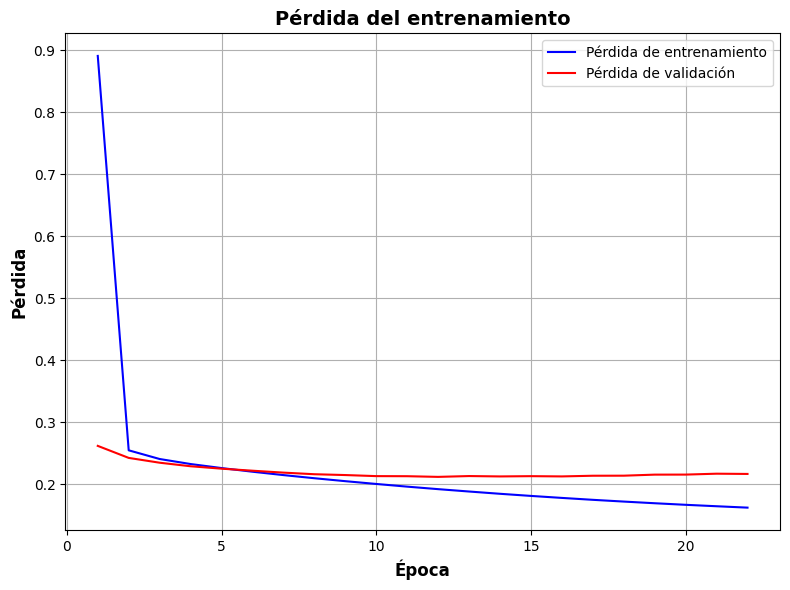

In [ ]:
graficar_historial_entrenamiento(historial)

In [ ]:
best_epoch = np.argmin(historial.history['loss'])
print(f"Mejor época (loss más bajo): {best_epoch}")
print(f"loss: {historial.history['loss'][best_epoch]:.4f}")

Mejor época (loss más bajo): 21
loss: 0.1625


El gráfico del loss muestra una tendencia claramente decreciente durante las primeras épocas, con una estabilización progresiva a medida que el entrenamiento avanza. El valor mínimo del loss de validación se alcanza en la época 21 con un valor de 0.1625, lo que indica que el modelo logró minimizar el error en la predicción de las secuencias del conjunto de validación. Esta métrica resulta útil para monitorear el proceso de optimización, ya que refleja directamente cuánto se alejan las predicciones del modelo de las salidas esperadas a nivel de token.

Por otro lado, no se incluye el análisis del accuracy en este caso, ya que en tareas de generación de lenguaje natural con modelos tipo Transformer, esta métrica no es del todo representativa. El accuracy mide la coincidencia exacta entre tokens generados y esperados, pero no considera alternativas válidas que podrían ser diferentes pero igualmente correctas o coherentes en contexto. Por ello, aunque el loss sigue siendo relevante como guía de entrenamiento, la evaluación de desempeño general se complementa mejor con métricas especializadas como BLEU, que capturan mejor la calidad lingüística y contextual de las respuestas generadas.

Ya con el modelo entrenado, veremos qué nos puede responder con una simple sentencia. Para eso, se define la función decode_sequence, que se encarga de tomar una frase de entrada y generar una respuesta automática usando el modelo entrenado.

In [ ]:
def decode_sequence(input_text, tokenizer, model, max_len=258):
    input_seq = tokenizer.texts_to_sequences([input_text])
    input_seq = pad_sequences(input_seq, maxlen=max_len, padding='post')
    decoder_input = [tokenizer.word_index['starttoken']]
    output = []
    for _ in range(max_len):
        decoder_input_seq = pad_sequences([decoder_input], maxlen=max_len, padding='post')
        predictions = model.predict([input_seq, decoder_input_seq], verbose=0)
        predicted_id = np.argmax(predictions[0, len(decoder_input) - 1])
        if predicted_id == tokenizer.word_index.get('endtoken'):
            break
        output.append(predicted_id)
        decoder_input.append(predicted_id)
    decoded_words = [tokenizer.index_word.get(i, '') for i in output]
    return ' '.join(decoded_words)

In [ ]:
response = decode_sequence("hi, what is your name?", tokenizer, model, max_len=258)
print("Respuesta del modelo:", response)

Respuesta del modelo: my name is li lin


La respuesta generada por el modelo: "my name is li lin" demuestra que ha aprendido a producir frases gramaticalmente correctas y coherentes dentro del estilo del corpus utilizado.

## 4. Evaluación del Modelo

Una vez finalizado el entrenamiento, es importante evaluar el rendimiento del modelo sobre el conjunto de prueba, el cual contiene datos no vistos previamente. Esto permite medir qué tan bien generaliza el modelo a nuevas conversaciones. A continuación, se utiliza el método evaluate() de Keras para calcular la pérdida (loss) y la precisión (accuracy) sobre el conjunto de test, utilizando como entradas las secuencias de entrada y las correspondientes secuencias del decoder.

In [ ]:
loss, accuracy = model.evaluate([x_test_pad, decoder_in_test], decoder_target_test, batch_size=128)
print(f"Loss en test: {loss:.4f}")
print(f"Accuracy en test: {accuracy:.4f}")

53/53 ━━━━━━━━━━━━━━━━━━━━ 9s 176ms/step - accuracy: 0.9628 - loss: 0.2156
Loss en test: 0.2203
Accuracy en test: 0.9619


Los resultados obtenidos durante la evaluación final del modelo muestran una pérdida (loss) de 0.22 y una precisión (accuracy) de 96% en el conjunto de prueba. Esto indica que el modelo logró un muy buen desempeño general, ya que mantiene una alta precisión incluso sobre datos no vistos durante el entrenamiento. Aunque quizas esto no se vea reflejado en la respuesta del modelo

Para complementar la evaluación del modelo, se incorpora la métrica BLEU (Bilingual Evaluation Understudy), ampliamente utilizada en tareas de traducción automática y generación de lenguaje natural. Esta métrica compara la secuencia generada por el modelo con una o más referencias humanas, evaluando el grado de coincidencia mediante la comparación de fragmentos n-grama (grupos de n palabras consecutivas).

En esta implementación, se calcula el BLEU-1, es decir, se utiliza un enfoque basado en unigramas (n=1). Esto significa que la métrica evalúa la precisión de las palabras individuales generadas por el modelo, sin considerar la secuencia ni la fluidez gramatical más allá del nivel palabra a palabra.

Se evalúan todas las muestras del conjunto de prueba, y se utiliza una función de suavizado para evitar que las puntuaciones sean cero cuando no hay coincidencias exactas. Además, se imprime un resumen con las primeras predicciones generadas, lo que permite observar de manera cualitativa el comportamiento del modelo frente a ejemplos reales.

In [ ]:
# Ejemplo de evaluación del modelo usando BLEU o ROUGE
# predictions = model.predict(test_data)
# print("BLEU Score:", sentence_bleu(reference_sentences, predictions))
def evaluar_bleu(input_texts, target_texts, model, tokenizer, max_len=280, n_muestras=100):
    scores = []
    n_muestras = min(n_muestras, len(input_texts))
    smooth_fn = SmoothingFunction().method1

    for i in range(n_muestras):
        entrada = input_texts[i]

        referencia = target_texts[i].replace('starttoken', '').replace('endtoken', '').strip().split()

        prediccion = decode_sequence(entrada, tokenizer, model, max_len).strip().split()

        bleu = sentence_bleu([referencia], prediccion, smoothing_function=smooth_fn)
        scores.append(bleu)

        if i < 5:
            print(f"Entrada: {entrada}")
            print(f"Referencia: {' '.join(referencia)}")
            print(f"Predicción: {' '.join(prediccion)}")
            print(f"BLEU: {bleu:.4f}\n")

    print(f"BLEU promedio sobre {n_muestras} muestras: {np.mean(scores):.4f}")

In [ ]:
evaluar_bleu(x_test, y_test_tok, model, tokenizer, max_len=max_len, n_muestras=len(x_test))

Entrada: Hey man , you wanna buy some weed ?
Referencia: Some what ?
Predicción: yes i am sorry but i can't wait for a moment
BLEU: 0.0000

Entrada: Some what ?
Referencia: Weed ! You know ? Pot , Ganja , Mary Jane some chronic !
Predicción: i want to go to the cinema
BLEU: 0.0000

Entrada: Weed ! You know ? Pot , Ganja , Mary Jane some chronic !
Referencia: Oh , umm , no thanks .
Predicción: yes i think so i can do it
BLEU: 0.0000

Entrada: Oh , umm , no thanks .
Referencia: I also have blow if you prefer to do a few lines .
Predicción: what do you want to do
BLEU: 0.0298

Entrada: I also have blow if you prefer to do a few lines .
Referencia: No , I am ok , really .
Predicción: what do you mean
BLEU: 0.0000

BLEU promedio sobre 6740 muestras: 0.0079


El análisis de los resultados obtenidos mediante la métrica BLEU revela un desempeño limitado del modelo en términos de generación de respuestas relevantes. Aunque en muchos casos las respuestas producidas por el modelo son gramaticalmente correctas y coherentes a nivel estructural, el puntaje BLEU promedio fue extremadamente bajo (0.0079), evidenciando una escasa coincidencia léxica con las respuestas esperadas. Esto se debe principalmente a que el BLEU-1 utilizado se basa en unigramas, es decir, en la comparación palabra por palabra, sin tener en cuenta la semántica ni la fluidez general de la oración. Así, aunque las frases generadas pueden sonar naturales, al no coincidir con las palabras exactas de la referencia, obtienen una puntuación nula o muy baja.

Además, las respuestas generadas no solo difieren léxicamente, sino que en la mayoría de los casos no son atingentes al contexto del diálogo, lo que indica que el modelo no ha aprendido a responder de forma adecuada en función de la intención comunicativa. Por ejemplo, ante la oferta que la primera persona ofrece, el modelo responde con frases como “i want to go to the cinema”, lo cual resulta incoherente en términos del intercambio conversacional. Esto pone de manifiesto una debilidad tanto en la comprensión del input como en la generación contextual de las respuestas.

Estos resultados evidencian la necesidad de incorporar métricas complementarias que consideren otros aspectos del lenguaje, como el BLEU-3 o BLEU-4, que evalúan n-gramas de mayor longitud y, por ende, capturan mejor las relaciones entre palabras consecutivas. Asimismo, sería recomendable incluir métricas como ROUGE, que se enfocan en la recuperación de información y podrían ofrecer una mejor perspectiva de la calidad generativa cuando las coincidencias exactas son bajas, pero existe una cierta similitud en el contenido global. En definitiva, aunque el modelo logra construir frases válidas desde el punto de vista sintáctico, aún carece de una capacidad sólida para generar respuestas contextualmente relevantes, lo que limita su utilidad en tareas de diálogo realista.

## 5. Presentación de Resultados y Conclusiones

El modelo Transformer básico desarrollado logró aprender estructuras lingüísticas del dataset DailyDialog, generando respuestas gramaticalmente correctas y sintácticamente coherentes en muchos casos. Los resultados de entrenamiento evidencian una disminución sostenida del loss, alcanzando su mínimo en la época 21, lo cual indica un aprendizaje efectivo del modelo en términos de predicción de tokens.

Sin embargo, la métrica BLEU unigrama reflejó que la semántica entre las respuestas generadas y las referencias originales es aún limitada, evidenciando que el modelo no logra capturar con precisión la intención comunicativa ni el contenido semántico esperado. Las respuestas suelen ser genéricas y poco contextuales, lo cual limita su utilidad en escenarios reales de conversación.

Esto evidencia que métricas utlizadas no bastan para evaluar modelos de generación de lenguaje natural. En este contexto, es clave complementar con métricas como un BLEU-3 o BLEU-4 o ROUGE, que consideran coincidencias a nivel de frases y secuencias, proporcionando una mejor estimación de la calidad semántica y contextual de las respuestas. A futuro, se podrían explorar ajustes en la arquitectura, ampliación del corpus de entrenamiento, o mejoras en la etapa de decodificación para fortalecer la coherencia y relevancia de las salidas generadas.



<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=952c4989-d7be-4048-8bbc-02e7b294e3b0' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>